# Coursework for Artificial Intelligence M COMPSCI5087 2024-2025

## Imports

In [1]:
import os, sys
import networkx as nx
# from mazelib import Maze
# from mazelib.generate.Prims import Prims
# import numpy as np
# import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [2]:
import maze as m
import solvers as solv
import plotter as pter

%load_ext autoreload
%autoreload 2

In [3]:
# # To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
# AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
# sys.path.append(AIMA_TOOLBOX_ROOT)

# import search as sch
# from notebookutils import show_map, display_visual

## Parameters

In [4]:
N = 11 # Number of tiles on the side
M = 3 # Number of wormholes

## Maze Generation

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are one-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), but from (0,7) you can't go to (2,1).

Problem details
- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

Important properties
- Branching factor? $b=5$, due to the 5 possible actions; could be optimistically lowered to 3 for most cases, since most tiles are only connected to 2 neighbours.
- Depth of the solution? $d\leq 4(N-2)^2$ with no teleportation links, effectively less with teleportation links

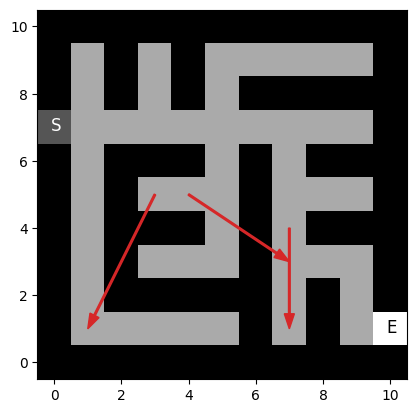

In [5]:
maze_problem = m.wormholes_maze_problem(N, M, show_plots=True)

In [6]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_problem.graph.graph_dict)

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_01_01': {'S_01_02': 1, 'S_02_01': 1}, 'S_02_01': {'S_01_01': 1, 'S_03_01': 1}, 'S_03_01': {'S_02_01': 1, 'S_04_01': 1}, 'S_04_01': {'S_03_01': 1, 'S_05_01': 1}, 'S_05_01': {'S_04_01': 1}, 'S_07_01': {'S_07_02': 1}, 'S_09_01': {'S_09_02': 1, 'S_10_01': 1}, 'S_10_01': {'S_09_01': 1}, 'S_01_02': {'S_01_01': 1, 'S_01_03': 1}, 'S_07_02': {'S_07_01': 1, 'S_07_03': 1}, 'S_09_02': {'S_09_01': 1, 'S_09_03': 1}, 'S_01_03': {'S_01_02': 1, 'S_01_04': 1}, 'S_03_03': {'S_04_03': 1}, 'S_04_03': {'S_03_03': 1, 'S_05_03': 1}, 'S_05_03': {'S_05_04': 1, 'S_04_03': 1}, 'S_07_03': {'S_07_02': 1, 'S_07_04': 1, 'S_08_03': 1}, 'S_08_03': {'S_07_03': 1, 'S_09_03': 1}, 'S_09_03': {'S_09_02': 1, 'S_08_03': 1}, 'S_01_04': {'S_01_03': 1, 'S_01_05': 1}, 'S_05_04': {'S_05_03': 1, 'S_05_05': 1}, 'S_07_04': {'S_07_03': 1, 'S_07_05': 1, 'S_07_01': 1}, 'S_01_05': {'S_01_04': 1, 'S_01_06': 1}, 'S_03_05': {'S_04_05': 1, 'S_01_01': 1}, 'S_04_05'

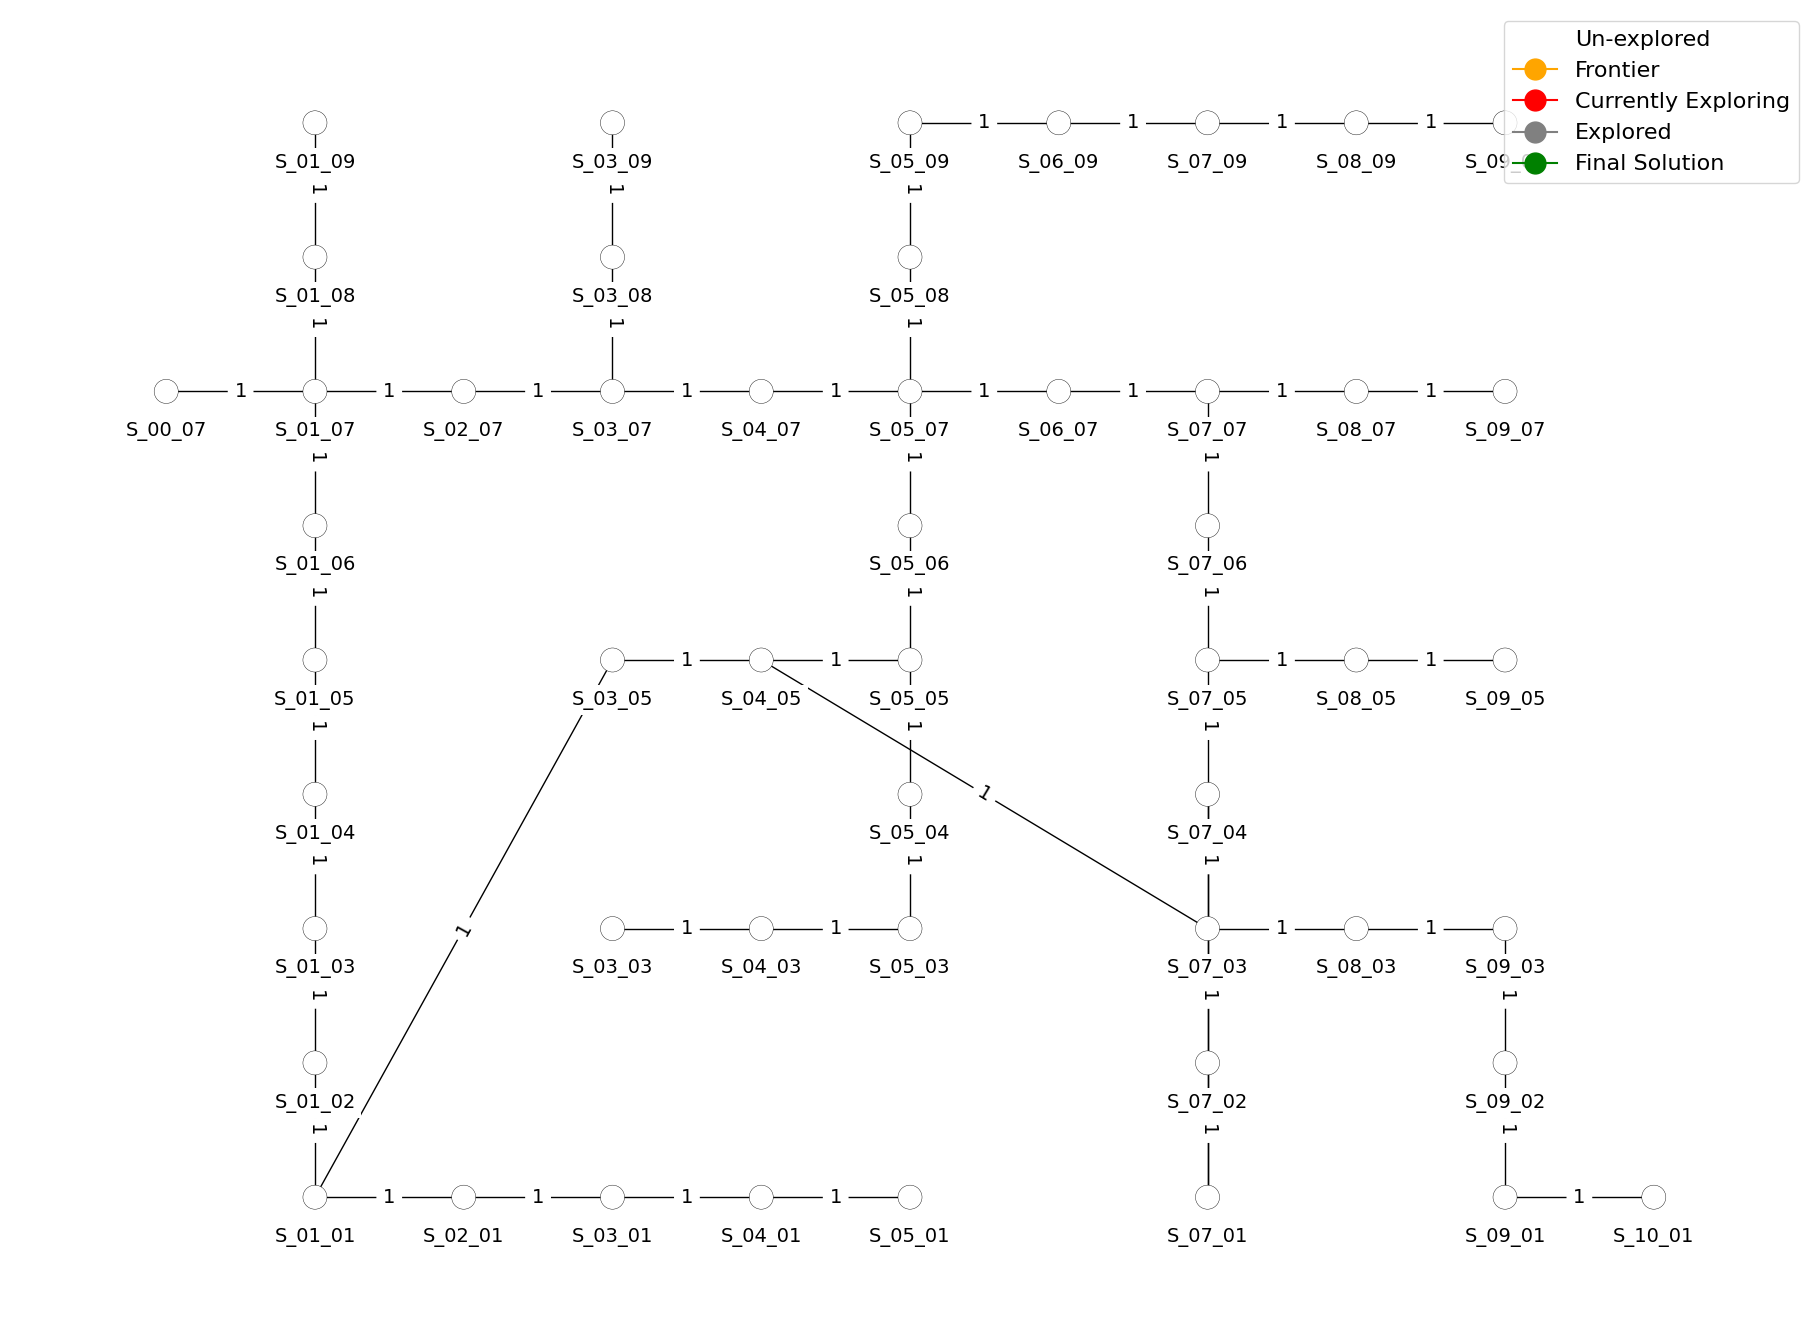

In [7]:
m.show_wormholes_maze_problem(maze_problem)

In [8]:
branching_factor = max([len(v) for (k,v) in maze_problem.graph.graph_dict.items()])
print("Branching factor", branching_factor)

Branching factor 4


## Solve the problem

The **heuristic function** $h$ is an arbitrary, non-negative, problem-specific function with one constrain: if $n$ is a goal node, then $h(n)=0$.

_The tree-search version of A-star is optimal if the heuristic function is **admissible**_. 

A heuristic function is admissible if it never overestimates the cost to reach a goal, i.e. an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is. _The most optimistic agent going down a wormhole will always assume that a wormhole can take you right to the exit._

_The graph-search version of A-star is optimal if the heuristic function is **consistent**_. 

A heuristic function is consistent if, for every node $n$ and every successor $n'$ of $n$ generated by any action $a$, the estimated cost of reaching the goal from $n$ is no greater than the step cost of getting to $n'$ plus the estimated cost of reaching the goal from $n'$:

$h(n) \leq c(n,a,n') + h(n')$

This is a form of the general triangle inequality. 

"For an admissible heuristic, the inequality makes perfect sense: if there were a route from $n$ to $G_n$ via $n'$ that was cheaper than $h(n)$, that would violate the property that $h()n)$is a lower bound on the cost to reach $G_n$" (Russel, S, & Norvig, P.: _Artificial Intelligence: A Modern Approach_, 3rd edition, Pearson Education, 2010, USA)

If $h$ is consistent, then the values of $f(n)$ along any path are nondecreasing.

_Unfortunetely, my heuristic function is **not consistent nor admissible**_

_The reason why I still chose A-star is because it strikes a good complexity balance, most probably reaching a good solution with less iterations that uniformed search methods such as DFS and BFS._

In [11]:
all_node_colors=[]
iterations, solution_path, all_node_colors = solv.wormholes_maze_A_star_solver(maze_problem)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


>> Iteration 0 >> Setting up the problem
>> Iteration 1 >> Adding the start point
>> Iteration 2 >> Exploring a node in the frontier
== Node (0, <Node S_00_07>, None) popped out
Will go over the following childs: [<Node S_01_07>]
== Child <Node S_01_07>
>> Iteration 3 >> Adding that child to the frontier
Node position [1 7]
Distance to the goal 10.816653826391969
Added (11.816653826391969, <Node S_01_07>, <Node S_00_07>)
>> Iteration 4 >> Finished exploring a node
Current queue [(11.816653826391969, <Node S_01_07>, <Node S_00_07>)]
>> Iteration 5 >> Exploring a node in the frontier
== Node (11.816653826391969, <Node S_01_07>, <Node S_00_07>) popped out
Will go over the following childs: [<Node S_01_06>, <Node S_01_08>, <Node S_00_07>, <Node S_02_07>]
== Child <Node S_01_06>
>> Iteration 6 >> Adding that child to the frontier
Node position [1 6]
Distance to the goal 10.295630140987
Added (12.295630140987, <Node S_01_06>, <Node S_01_07>)
== Child <Node S_01_08>
>> Iteration 7 >> Adding t

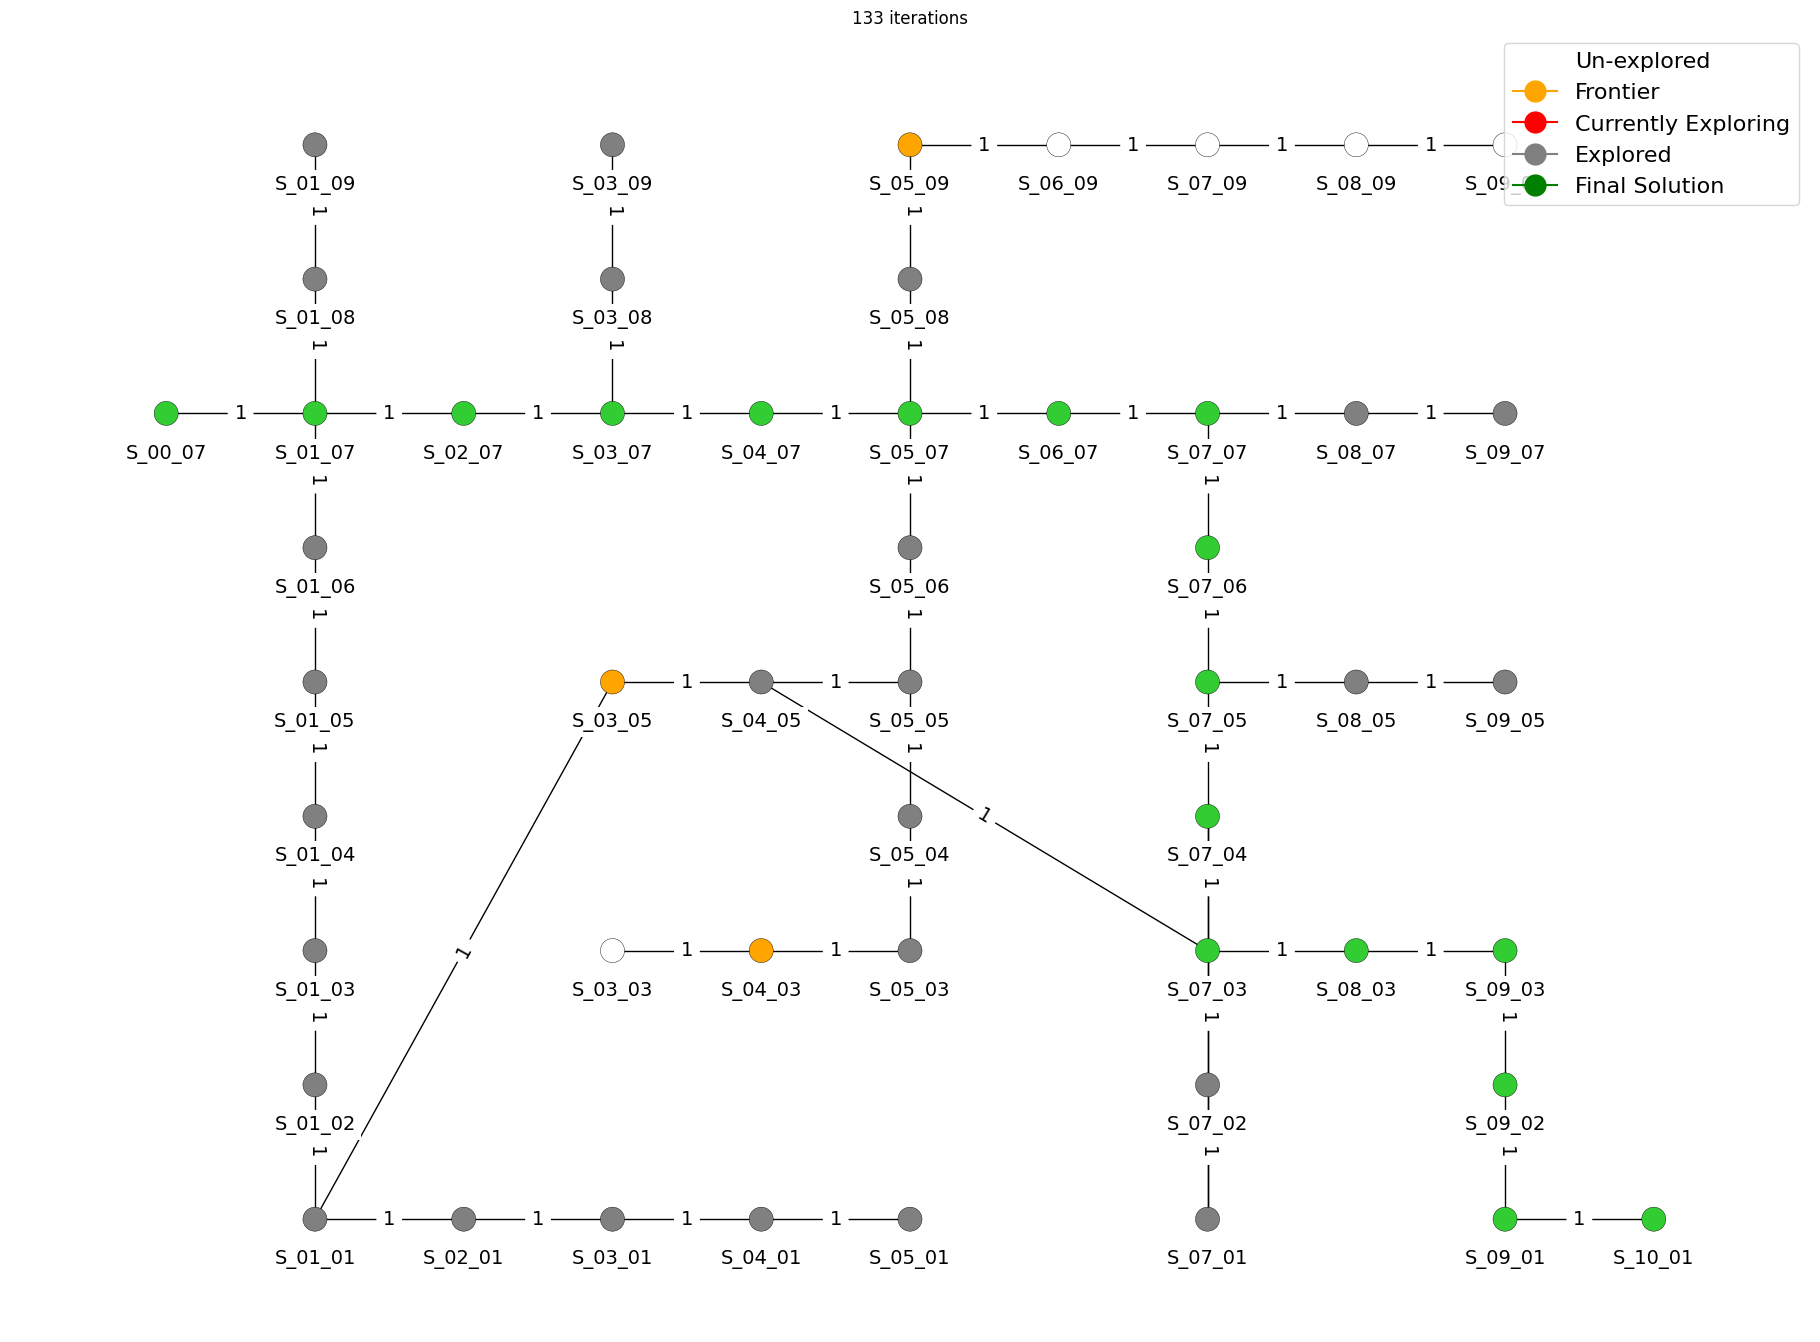

In [12]:
m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], iterations)

In [11]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    pter.display_visual(m.get_wormholes_maze_graphic_data(maze_problem), user_input=False, 
                   algorithm=lambda problem : solv.wormholes_maze_A_star_solver(problem, verbose=False), 
                   problem=maze_problem)
    maze_problem.verbose = True

### Analysis

Mmmm... It had already explored S_07_03, arriving from another node, so it ignores it once it gets there from the wormhole.

Worse yet, even if I said "explore the wormhole exits, even if they already existed", it would still run into trouble with S_08_03 having been already explored.

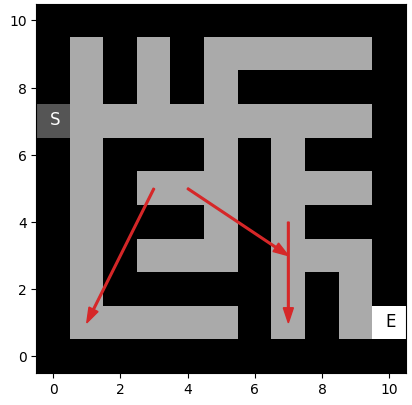

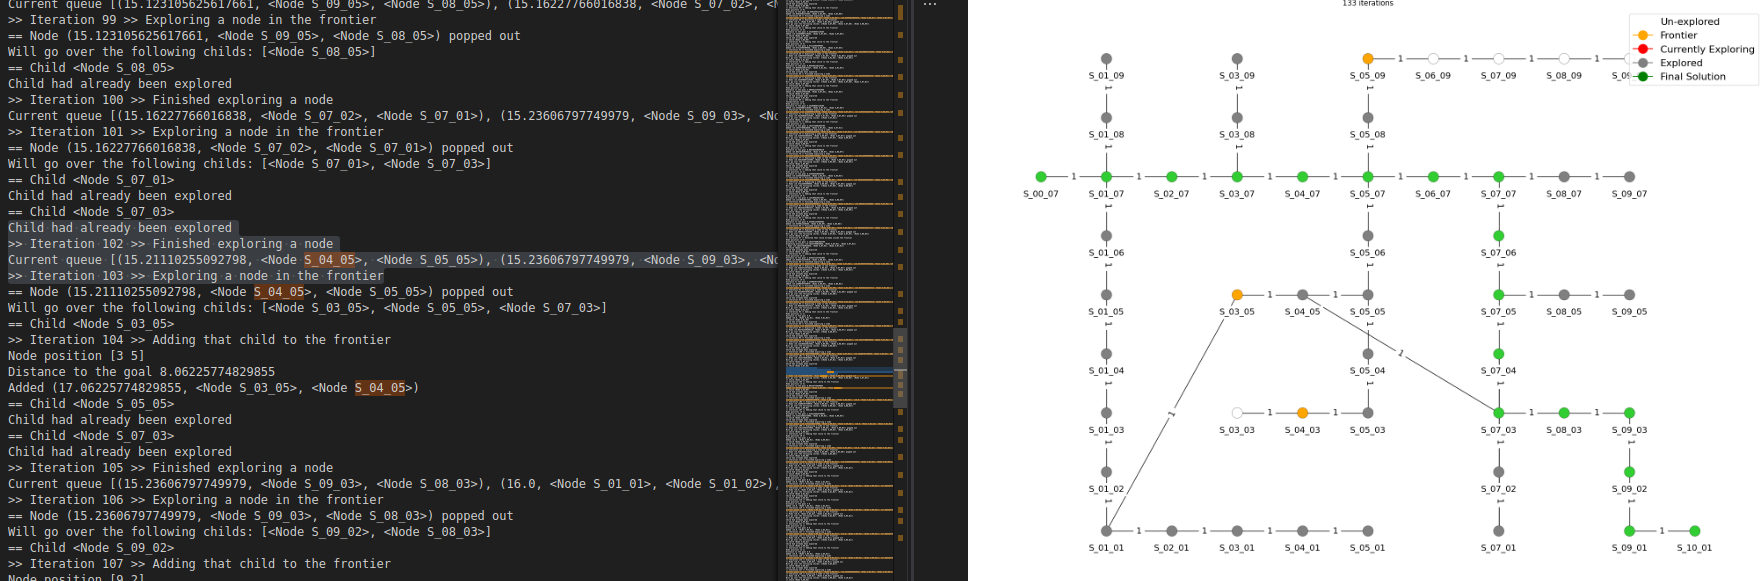


**Discovered I was actually using the wrong distance. With the Euclidean distance...**

This finally seems to be finding the optimal solution, even in that last case where I couldn't find it before!

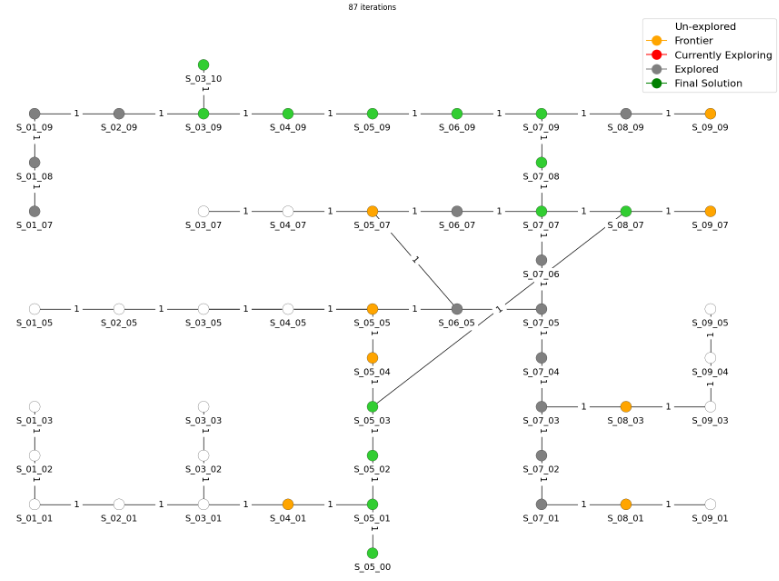

**I'm now trying the consistent h, without any updates to the node**

Still not always getting my own optimal solution.

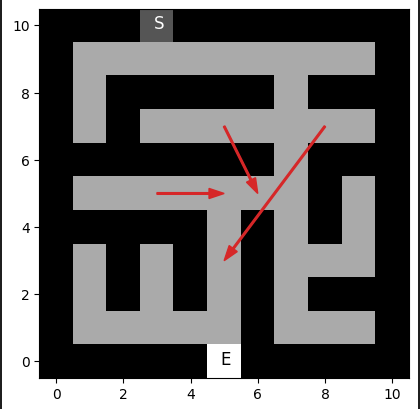

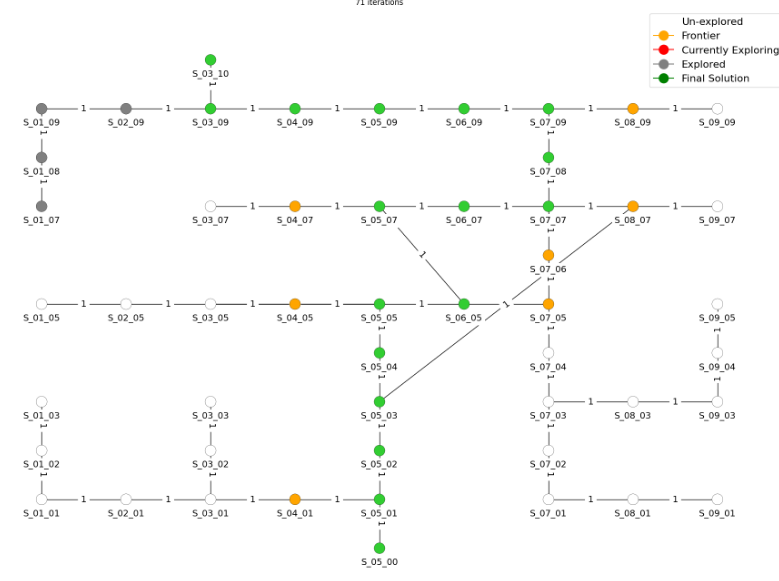

**I'm now using a consistent h**

Ouch! Still not getting optimal solution in all cases

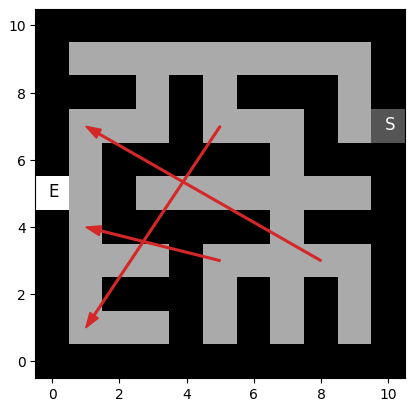

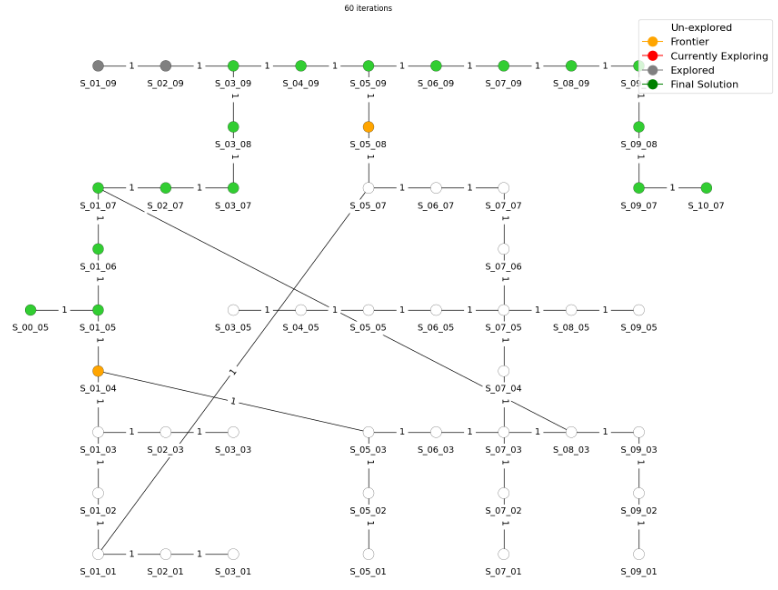

**I'm now updating my h after exploring the wormhole**

Ouch! Never got to explore the upper path and find the shortcut

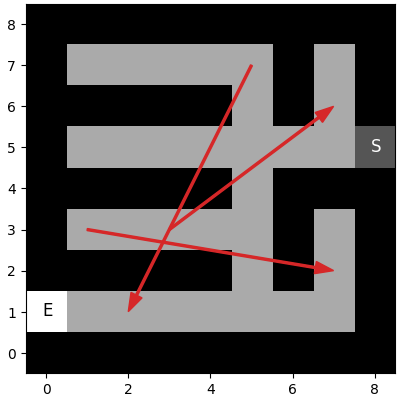

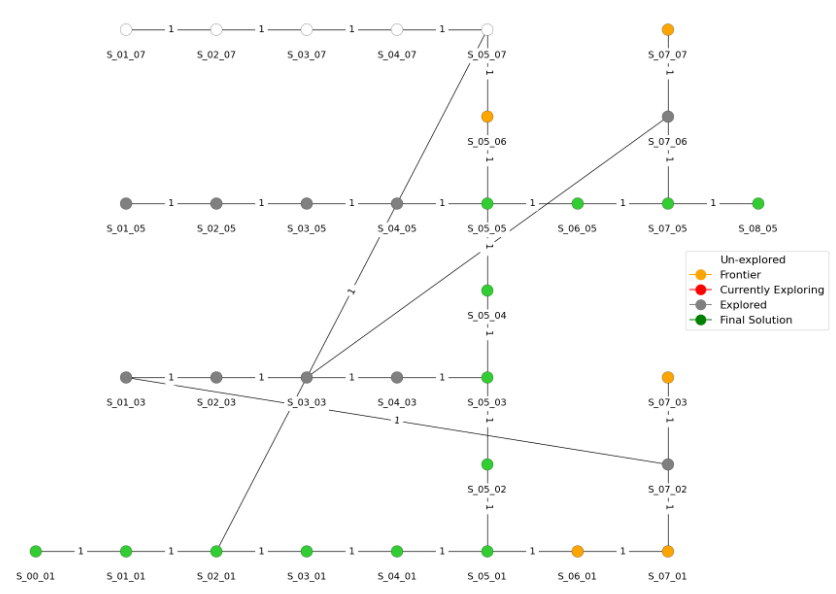

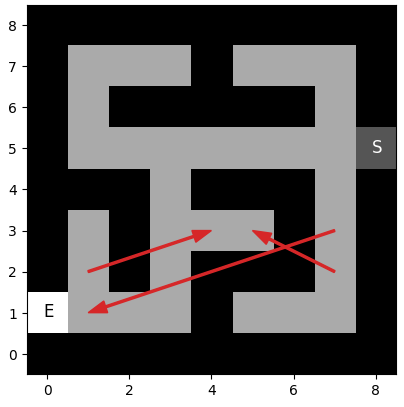

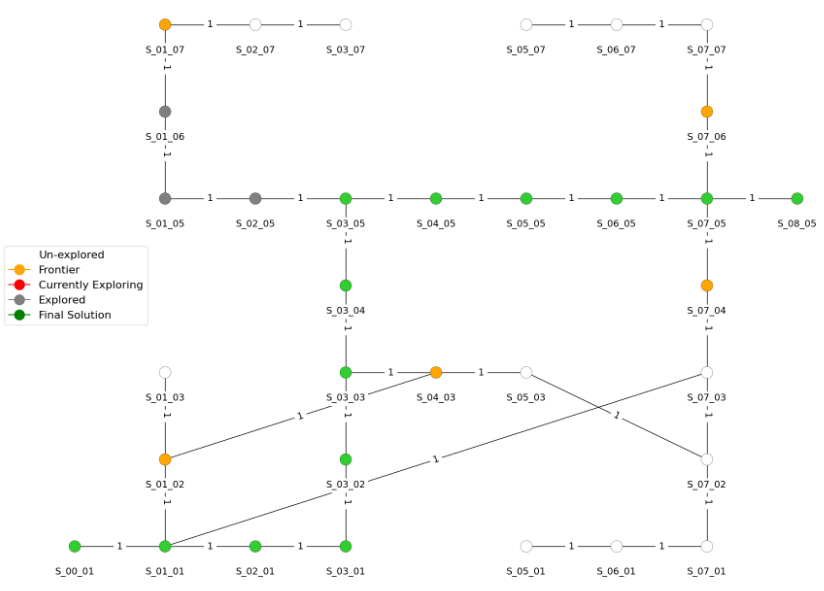

Curiously enough, in this case it was better not to take the wormhole:

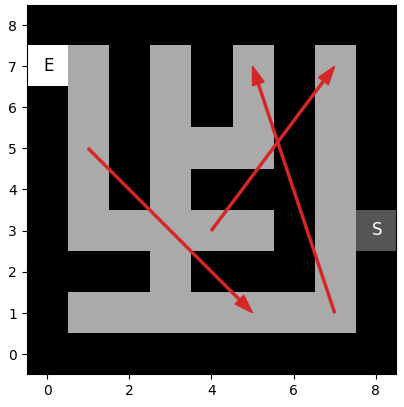

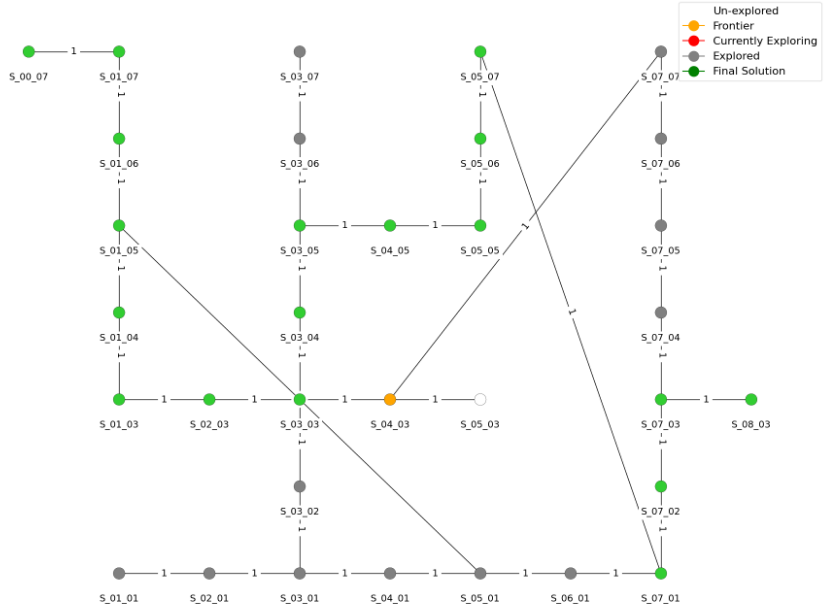